In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/invasive-species-monitoring/train_labels.csv.zip
/kaggle/input/invasive-species-monitoring/sample_submission.csv.zip
/kaggle/input/invasive-species-monitoring/test.7z
/kaggle/input/invasive-species-monitoring/train.7z


In [2]:

!pip install py7zr 

import py7zr

image_files = py7zr.SevenZipFile('/kaggle/input/invasive-species-monitoring/train.7z', 'r')
image_files.extractall(path='/kaggle/working/data')
image_files.close()

test_image = py7zr.SevenZipFile('/kaggle/input/invasive-species-monitoring/test.7z', 'r')
test_image.extractall(path='/kaggle/working/data')
test_image.close()

  Obtaining dependency information for py7zr from https://files.pythonhosted.org/packages/c0/39/71263be4c6081e1788f4da35e937fca1808914b0d98a04bd44255b948699/py7zr-0.20.8-py3-none-any.whl.metadata
  Obtaining dependency information for pycryptodomex>=3.16.0 from https://files.pythonhosted.org/packages/78/74/e22cc8c2bb5e4d746952b22a2f0ef98988851804c35d89890d8ea6c22f18/pycryptodomex-3.19.1-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pyzstd>=0.15.9 from https://files.pythonhosted.org/packages/02/97/57de14ccb0d033464aabc5110eb2f9dc717c97e17f2ffc1235680a27e5de/pyzstd-0.15.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pyppmd<1.2.0,>=1.1.0 from https://files.pythonhosted.org/packages/09/76/61db4268a439cfba8736b14130d928d199633fab2360a2c5043332a427d2/pyppmd-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pybc

In [3]:
import zipfile 
train_label = zipfile.ZipFile('/kaggle/input/invasive-species-monitoring/train_labels.csv.zip', 'r')
train_label.extractall(path="/kaggle/working/data")
train_label.close()

sub_label = zipfile.ZipFile('/kaggle/input/invasive-species-monitoring/sample_submission.csv.zip', 'r')
sub_label.extractall(path="/kaggle/working/data")
sub_label.close()

In [4]:
training_ds=pd.read_csv('/kaggle/working/data/train_labels.csv')
training_ds.head()
image_folder = '/kaggle/working/data/train/'
image_paths = [os.path.join(image_folder, f"{image_id}.jpg") for image_id in training_ds.iloc[:, 0]]
training_labels = tf.convert_to_tensor(training_ds.iloc[:, 1], dtype=tf.int32)

In [5]:
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def process_image(image_path):
    # Load image in BGR format
    img_bgr = cv2.imread(image_path)
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Resize if needed
    img_rgb = cv2.resize(img_rgb, (244, 244))  # Adjust size as needed
    
    # Convert to array
    img_array = img_to_array(img_rgb)
    
    return img_array
# Load and preprocess each image in the array
image_tensors = [process_image(image_path) for image_path in image_paths]

# Convert the list of image tensors to a TensorFlow tensor
training_data = tf.convert_to_tensor(image_tensors)


In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming 'your_dataset' is your TensorFlow dataset and 'your_labels' is your corresponding labels
your_dataset = training_data # Replace with your actual dataset
your_labels = training_labels  # Replace with your actual labels

# Calculate the total number of samples
num_samples = len(your_labels)

# Convert the dataset and labels to NumPy arrays
your_data_array = np.array(list(your_dataset))
your_labels_array = np.array(list(your_labels))

# Define the ratio for splitting (e.g., 80% training, 20% testing)
train_ratio = 0.7
test_ratio = 1 - train_ratio

# Calculate the number of samples for training and testing
num_train_samples = int(train_ratio * num_samples)

# Split the dataset and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    your_data_array, your_labels_array, test_size=test_ratio, stratify=your_labels_array, random_state=42
)



In [7]:
sample_submission = pd.read_csv("/kaggle/working/data/sample_submission.csv")
img_path = "/kaggle/working/data/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i][0])
    file_paths.append( img_path + str(int(sample_submission.iloc[i][0])) +'.jpg' )
    
test_names = np.array(test_names)
test_images = []
for file_path in file_paths:
    img_bgr = cv2.imread(file_path)
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Resize if needed
    img_rgb = cv2.resize(img_rgb, (244, 244))  # Adjust size as needed
    
    # Convert to array
    img_array = img_to_array(img_rgb)
    test_images.append(img_array)
    

test_images = tf.convert_to_tensor(test_images)

/tmp/ipykernel_27/3259038925.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_names.append(sample_submission.iloc[i][0])
/tmp/ipykernel_27/3259038925.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_paths.append( img_path + str(int(sample_submission.iloc[i][0])) +'.jpg' )


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Now you can use ImageDataGenerator in your code

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=training_data[0].shape)
fine_tune = 0
if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
        layer.trainable = False
else:
    for layer in base_model.layers:
        layer.trainable = False

## Preprocessing input
training_data = preprocess_input(training_data)
test_images = preprocess_input(test_images)

from tensorflow.keras import layers, models

flatten_layer = layers.Flatten(input_shape=base_model.output_shape[1:])
dense_layer_1 = layers.Dense(256, activation='relu')
batch_norm_1 = layers.BatchNormalization()
dropout_1 = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(128, activation='relu')
batch_norm_2 = layers.BatchNormalization()
dropout_2 = layers.Dropout(0.2)
prediction_layer = layers.Dense(1, activation='sigmoid')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    batch_norm_1,  
    layers.Activation('relu'),  
    dropout_1,
    dense_layer_2,
    batch_norm_2,  
    layers.Activation('relu'),  
    dropout_2,
    prediction_layer
])
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=optimizers.Adam(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0 

In [9]:
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),steps_per_epoch=X_train.shape[0] // 32, epochs=50, validation_data=(X_test,y_test), batch_size=32, callbacks=[es])

Epoch 1/50
50/50 [==============================] - 36s 539ms/step - loss: 0.4217 - accuracy: 0.8100 - val_loss: 0.2749 - val_accuracy: 0.9187
Epoch 2/50
50/50 [==============================] - 22s 439ms/step - loss: 0.2845 - accuracy: 0.8748 - val_loss: 0.2593 - val_accuracy: 0.9100
Epoch 3/50
50/50 [==============================] - 22s 439ms/step - loss: 0.2758 - accuracy: 0.8901 - val_loss: 0.3001 - val_accuracy: 0.8882
Epoch 4/50
50/50 [==============================] - 23s 451ms/step - loss: 0.2398 - accuracy: 0.9053 - val_loss: 0.2630 - val_accuracy: 0.8984
Epoch 5/50
50/50 [==============================] - 23s 451ms/step - loss: 0.2261 - accuracy: 0.9022 - val_loss: 0.1828 - val_accuracy: 0.9289
Epoch 6/50
50/50 [==============================] - 22s 436ms/step - loss: 0.2196 - accuracy: 0.9244 - val_loss: 0.2879 - val_accuracy: 0.8926
Epoch 7/50
50/50 [==============================] - 22s 444ms/step - loss: 0.2005 - accuracy: 0.9269 - val_loss: 0.1865 - val_accuracy: 0.9231

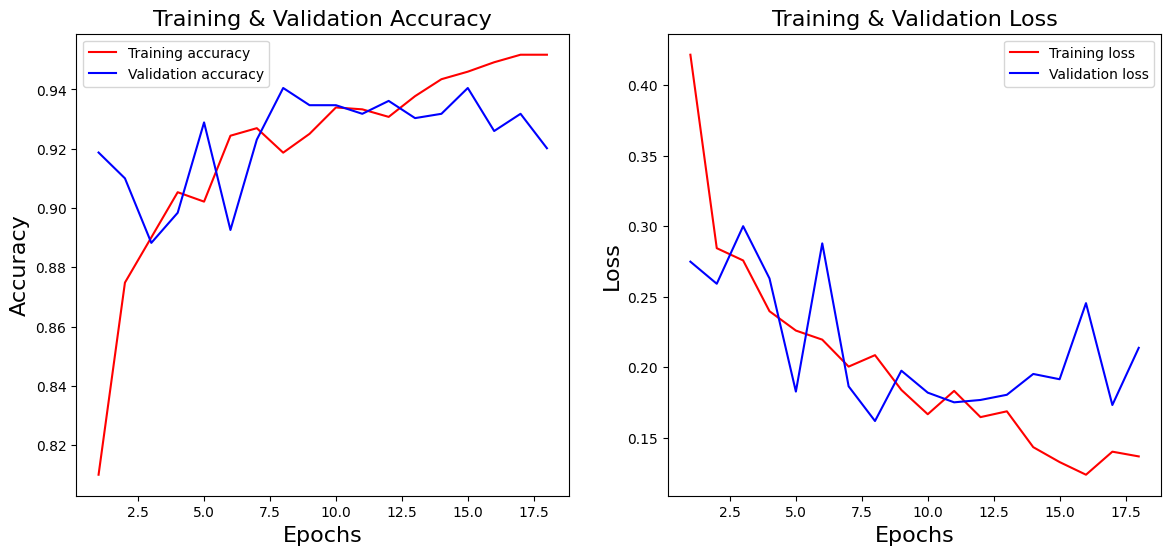

In [10]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [11]:
print("Training loss: {:.2f} / Validation loss: {:.2f}".\
      format(history.history['loss'][-1], history.history['val_loss'][-1]))
print("Training accuracy: {:.2f}% / Validation accuracy: {:.2f}%".\
      format(100*history.history['accuracy'][-1], 100*history.history['val_accuracy'][-1]))

Training loss: 0.14 / Validation loss: 0.21
Training accuracy: 95.17% / Validation accuracy: 92.02%


In [12]:
predictions = model.predict(test_images)

48/48 [==============================] - 13s 265ms/step


In [13]:
sample_submission = pd.read_csv("/kaggle/working/data/sample_submission.csv")

for i, name in enumerate(test_names):
    inv = 0
    if(predictions[i] > 0.5) :
        inv =1
    else:
        inv=0
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] =  inv

sample_submission.to_csv("submit.csv", index=False)